## imports

In [1]:
import __init__
from __init__ import DATA_PATH
from __init__ import PACKAGE_PATH
from dce import DCE
from cluster import Cluster
from descriptor import rdkitDescriptors
import utilities
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


## read data and generate descriptors
* ground_truth using 60% BOD cut
* descriptor using float here

Number of Descriptor:68


(array([756.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 307.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

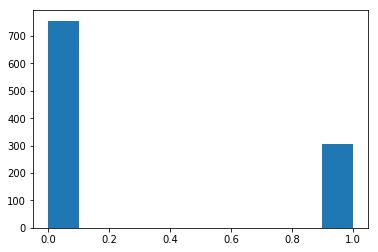

In [2]:
df = pd.read_csv(os.path.join(DATA_PATH,'BOD_RDKit_Descriptors_1063.csv'))
df['cleaned_bod'] = utilities.clean_out_of_bound(df['value (% BOD)'])
feat_float = rdkitDescriptors.batch_compute_all_descriptors(df['SMILES'],desc_type='float')
selected_float_feat = feat_float.loc[:,feat_float.nunique()>1]
print('Number of Descriptor:' + str(len(selected_float_feat.loc[0])))
      
df['bi_class_partition'] = utilities.divide_classes(df['cleaned_bod'], [60])
true_label_biclass = df['bi_class_partition'].values
plt.hist(df['bi_class_partition'])

## build model and train model

In [3]:
autoencoder_dims = [68,45,20]
dce = DCE(autoencoder_dims, n_clusters=2, update_interval=50)
dce.build_model()

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
dce.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 68)           0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 68)           272         input[0][0]                      
__________________________________________________________________________________________________
encoder_0 (Dense)               (None, 45)           3105        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
embedding_layer (Dense)         (None, 20)           920         encoder_0[0][0]                  
__________________________________________________________________________________________________
decoder_1 

### train model with default parameters

In [5]:
[y_pred, loss, delta_label] = dce.train_model(selected_float_feat.values,clustering_loss='kld', 
                                              decoder_loss='mse', clustering_loss_weight=0.5)

Instructions for updating:
Use tf.cast instead.
Epoch: 0
  Total_loss = 0.013096661;Delta_label = 0.0
  Clustering_loss = 0.0004416075; Decoder_loss = 0.025751716
Epoch: 50
  Total_loss = 0.00044994;Delta_label = 0.2671683913452493
  Clustering_loss = 7.758233e-06; Decoder_loss = 0.0008921218
Epoch: 100
  Total_loss = 0.00040052555;Delta_label = 0.08654750705550329
  Clustering_loss = 1.884415e-05; Decoder_loss = 0.00078220695
Epoch: 150
  Total_loss = 0.0003811842;Delta_label = 0.060206961429915336
  Clustering_loss = 5.686063e-05; Decoder_loss = 0.00070550776
Epoch: 200
  Total_loss = 0.00041499702;Delta_label = 0.05174035747883349
  Clustering_loss = 0.00019297081; Decoder_loss = 0.00063702324
Epoch: 250
  Total_loss = 0.0006413298;Delta_label = 0.027281279397930385
  Clustering_loss = 0.00069105864; Decoder_loss = 0.000591601
Epoch: 300
  Total_loss = 0.0014879194;Delta_label = 0.020696142991533398
  Clustering_loss = 0.0024102444; Decoder_loss = 0.0005655942
Epoch: 350
  Total_los

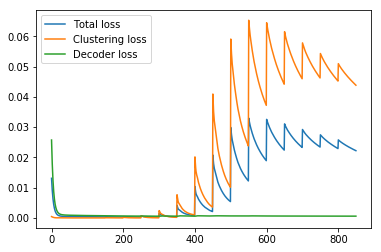

In [6]:
plt.plot(loss[0], label='Total loss')
plt.plot(loss[1], label='Clustering loss')
plt.plot(loss[2], label='Decoder loss')
plt.legend()

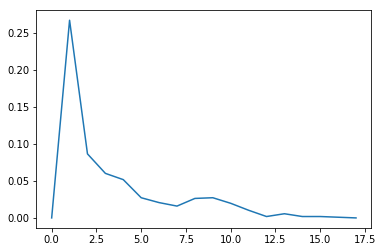

In [7]:
plt.plot(delta_label)

(array([575.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 488.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

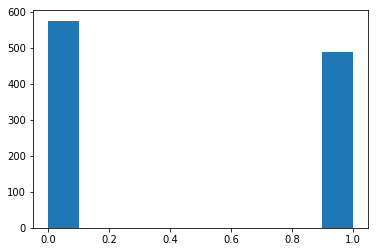

In [8]:
plt.hist(y_pred)

In [9]:
Cluster.true_label_metrics(true_label_biclass,y_pred,print_metric=True)

Metric with True label
adjusted rand score: 0.009759500246271636 
fowlkes_mallows : 0.548635890488515


{'adjusted_rand_score': 0.009759500246271636,
 'fowlkes_mallows_score': 0.548635890488515}

### Parameters for tuning:
* Hardening Function: order = {1,3,5,7,9}, strength > 1
* Opitmizer: {'adam', 'sgd'}, lr, decay
* update_interval 

In [24]:
autoencoder_dims = [68,45,20]
dce = DCE(autoencoder_dims, n_clusters=2, update_interval=50)
dce.build_model()
[y_pred, loss, delta_label] = dce.train_model(
    selected_float_feat.values,clustering_loss='kld', 
    decoder_loss='mse', clustering_loss_weight=0.05,
    hardening_order=3, hardening_strength=1.5)

Epoch: 0
  Total_loss = 0.011113219;Delta_label = 0.0
  Clustering_loss = 0.00037720535; Decoder_loss = 0.011678273
Epoch: 50
  Total_loss = 0.0008202251;Delta_label = 0.2605832549388523
  Clustering_loss = 2.0676947e-05; Decoder_loss = 0.0008623066
Epoch: 100
  Total_loss = 0.00071475666;Delta_label = 0.09125117591721543
  Clustering_loss = 9.283289e-05; Decoder_loss = 0.0007474895
Epoch: 150
  Total_loss = 0.00064314593;Delta_label = 0.0761994355597366
  Clustering_loss = 0.0004343961; Decoder_loss = 0.0006541328
Epoch: 200
  Total_loss = 0.0006602019;Delta_label = 0.04891815616180621
  Clustering_loss = 0.0019314018; Decoder_loss = 0.00059329666
Epoch: 250
  Total_loss = 0.00090465904;Delta_label = 0.03951081843838194
  Clustering_loss = 0.0074522933; Decoder_loss = 0.0005600467
Epoch: 300
  Total_loss = 0.0016834155;Delta_label = 0.04985888993414864
  Clustering_loss = 0.023328464; Decoder_loss = 0.0005442024
Epoch: 350
  Total_loss = 0.0031952807;Delta_label = 0.041392285983066796

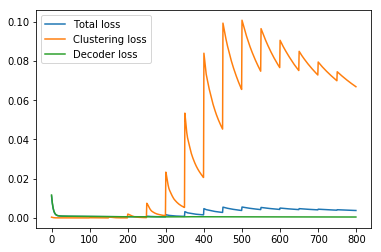

In [25]:
plt.plot(loss[0], label='Total loss')
plt.plot(loss[1], label='Clustering loss')
plt.plot(loss[2], label='Decoder loss')
plt.legend()

(array([553.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 510.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

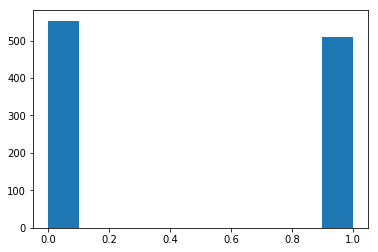

In [26]:
plt.hist(y_pred)

In [27]:
Cluster.true_label_metrics(true_label_biclass,y_pred,print_metric=True)

Metric with True label
adjusted rand score: -0.0009157115788744715 
fowlkes_mallows : 0.5423625820833834


{'adjusted_rand_score': -0.0009157115788744715,
 'fowlkes_mallows_score': 0.5423625820833834}